In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("sparkml").getOrCreate()

In [2]:
spark

In [3]:
# read data
df = spark.read.parquet("s3://finalproject502/df.parquet")

In [4]:
df.head()

Row(GLOBALEVENTID='611051912', SQLDATE=None, MonthYear='201512', Year='2015', FractionDate='2015.9699', Actor1Code='', Actor1Name='', Actor1CountryCode='', Actor1KnownGroupCode='', Actor1EthnicCode='', Actor1Religion1Code='', Actor1Religion2Code='', Actor1Type1Code='', Actor1Type2Code='', Actor1Type3Code='', Actor2Code='BUS', Actor2Name='BUSINESS', Actor2CountryCode='', Actor2KnownGroupCode='', Actor2EthnicCode='', Actor2Religion1Code='', Actor2Religion2Code='', Actor2Type1Code='BUS', Actor2Type2Code='', Actor2Type3Code='', IsRootEvent='1', EventCode='042', EventBaseCode='042', EventRootCode='04', QuadClass='1', GoldsteinScale=1.899999976158142, NumMentions=10, NumSources=1, NumArticles=10, AvgTone=0.7025761008262634, Actor1Geo_Type='0', Actor1Geo_FullName='', Actor1Geo_CountryCode='', Actor1Geo_ADM1Code='', Actor1Geo_Lat=None, Actor1Geo_Long=None, Actor1Geo_FeatureID='', Actor2Geo_Type='4', Actor2Geo_FullName='Tanjung, Pahang, Malaysia', Actor2Geo_CountryCode='MY', Actor2Geo_ADM1Code=

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorIndexer
from pyspark.ml import Pipeline

In [6]:
# select features
new = df.select(df.GLOBALEVENTID, df.EventCode.cast("integer"), df.QuadClass.cast("integer"), df.GoldsteinScale, \
                df.NumSources, df.ActionGeo_Type.cast('integer'), df.ActionGeo_FeatureID.cast('integer'), df.AvgTone)

In [7]:
new = new.na.drop()
new.show()

+-------------+---------+---------+--------------+----------+--------------+-------------------+-----------+
|GLOBALEVENTID|EventCode|QuadClass|GoldsteinScale|NumSources|ActionGeo_Type|ActionGeo_FeatureID|    AvgTone|
+-------------+---------+---------+--------------+----------+--------------+-------------------+-----------+
|    611051912|       42|        1|           1.9|         1|             4|              94819|  0.7025761|
|    611051913|       10|        1|           0.0|         1|             5|            -231099|-0.73937154|
|    611051914|       10|        1|           0.0|         1|             4|            -246227|-0.73937154|
|    611051916|       43|        1|           2.8|         1|             4|              94819|  0.7025761|
|    611051917|       36|        1|           4.0|         1|             4|            -246227|-0.73937154|
|    611051918|       43|        1|           2.8|         1|             4|           -2403010|  0.7025761|
|    611051919|    

In [8]:
new.printSchema()

root
 |-- GLOBALEVENTID: string (nullable = true)
 |-- EventCode: integer (nullable = true)
 |-- QuadClass: integer (nullable = true)
 |-- GoldsteinScale: float (nullable = true)
 |-- NumSources: integer (nullable = true)
 |-- ActionGeo_Type: integer (nullable = true)
 |-- ActionGeo_FeatureID: integer (nullable = true)
 |-- AvgTone: float (nullable = true)



In [9]:
FEATURES_COL = ['EventCode', 'QuadClass', 'GoldsteinScale', 'NumSources', 'ActionGeo_Type', 'ActionGeo_FeatureID']

In [10]:
# combine features to vectors
vecAssembler = VectorAssembler(inputCols = FEATURES_COL, outputCol="features")
d = vecAssembler.transform(new)
df_kmeans = d.select('GLOBALEVENTID', 'features')
df_kmeans.show()

+-------------+--------------------+
|GLOBALEVENTID|            features|
+-------------+--------------------+
|    611051912|[42.0,1.0,1.89999...|
|    611051913|[10.0,1.0,0.0,1.0...|
|    611051914|[10.0,1.0,0.0,1.0...|
|    611051916|[43.0,1.0,2.79999...|
|    611051917|[36.0,1.0,4.0,1.0...|
|    611051918|[43.0,1.0,2.79999...|
|    611051919|[172.0,4.0,-5.0,1...|
|    611051920|[172.0,4.0,-5.0,1...|
|    611051921|[172.0,4.0,-5.0,1...|
|    611051922|[10.0,1.0,0.0,18....|
|    611051926|[36.0,1.0,4.0,1.0...|
|    611051927|[36.0,1.0,4.0,1.0...|
|    611051928|[71.0,2.0,7.40000...|
|    611051929|[20.0,1.0,3.0,8.0...|
|    611051930|[20.0,1.0,3.0,8.0...|
|    611051931|[20.0,1.0,3.0,1.0...|
|    611051932|[20.0,1.0,3.0,1.0...|
|    611051933|[42.0,1.0,1.89999...|
|    611051934|[70.0,2.0,7.0,1.0...|
|    611051935|[81.0,2.0,5.0,51....|
+-------------+--------------------+
only showing top 20 rows



In [11]:
# find the optimal K
cost = np.zeros(10)
for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans)
    cost[k] = model.computeCost(df_kmeans)

Text(0, 0.5, 'cost')

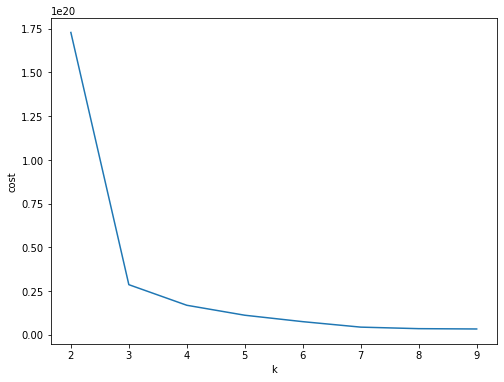

In [12]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),cost[2:10])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [13]:
# find where to seperate AvgTone
new.approxQuantile("AvgTone", [0.33, 0.67], 0.001)

[-3.7647814750671387, -0.4098014235496521]

In [14]:
new.describe('AvgTone').show()

+-------+-------------------+
|summary|            AvgTone|
+-------+-------------------+
|  count|           44495330|
|   mean|-2.2467026303740427|
| stddev|  3.820887230421528|
|    min|         -59.471684|
|    max|          25.431034|
+-------+-------------------+



In [15]:
# seperate AvgTone to new labels
from pyspark.sql.functions import when, expr 
new.createOrReplaceTempView("test")
ss = spark.sql("select GLOBALEVENTID, \
                       CASE when AvgTone > -3.77 then \
                            case when AvgTone <= -0.41 then 1 \
                                 else 2 \
                            end \
                       else 0 \
                       end AS label \
                       from test")
ss.show()

+-------------+-----+
|GLOBALEVENTID|label|
+-------------+-----+
|    611051912|    2|
|    611051913|    1|
|    611051914|    1|
|    611051916|    2|
|    611051917|    1|
|    611051918|    2|
|    611051919|    1|
|    611051920|    1|
|    611051921|    1|
|    611051922|    1|
|    611051926|    2|
|    611051927|    2|
|    611051928|    1|
|    611051929|    0|
|    611051930|    0|
|    611051931|    1|
|    611051932|    1|
|    611051933|    2|
|    611051934|    2|
|    611051935|    0|
+-------------+-----+
only showing top 20 rows



In [16]:
# K = 3, fit the model
kmeans = KMeans().setK(3).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

In [17]:
featureIndexer = VectorIndexer(inputCol="features", \
                               outputCol="indexedFeatures",\
                               maxCategories=4).fit(df_kmeans)

pipeline = Pipeline(stages=[featureIndexer, kmeans])
model = pipeline.fit(df_kmeans)
cluster = model.transform(df_kmeans)

In [18]:
transformed = cluster.select('GLOBALEVENTID', 'prediction')
transformed.show()

+-------------+----------+
|GLOBALEVENTID|prediction|
+-------------+----------+
|    611051912|         2|
|    611051913|         2|
|    611051914|         2|
|    611051916|         2|
|    611051917|         2|
|    611051918|         0|
|    611051919|         1|
|    611051920|         1|
|    611051921|         1|
|    611051922|         2|
|    611051926|         0|
|    611051927|         0|
|    611051928|         2|
|    611051929|         0|
|    611051930|         2|
|    611051931|         2|
|    611051932|         0|
|    611051933|         2|
|    611051934|         2|
|    611051935|         2|
+-------------+----------+
only showing top 20 rows



In [19]:
df_pred = transformed.join(ss, 'GLOBALEVENTID')
df_pred.show()

+-------------+----------+-----+
|GLOBALEVENTID|prediction|label|
+-------------+----------+-----+
|    498554248|         2|    1|
|    498554527|         2|    1|
|    498555431|         0|    0|
|    498555582|         2|    2|
|    498555732|         2|    1|
|    498556791|         2|    2|
|    498556928|         2|    1|
|    498557050|         2|    1|
|    498558291|         0|    2|
|    498558606|         2|    0|
|    498559642|         0|    1|
|    498560054|         2|    1|
|    498561337|         0|    0|
|    498561380|         2|    2|
|    498561738|         2|    1|
|    498562091|         2|    2|
|    498563314|         2|    0|
|    498563359|         2|    2|
|    498563555|         2|    1|
|    498565206|         0|    2|
+-------------+----------+-----+
only showing top 20 rows



In [20]:
# check if the prediction and the label are the same
df_pred = df_pred.withColumn('result', when(df_pred.prediction == df_pred.label, 'T').otherwise('F'))
df_pred.show()

+-------------+----------+-----+------+
|GLOBALEVENTID|prediction|label|result|
+-------------+----------+-----+------+
|    498554248|         2|    1|     F|
|    498554527|         2|    1|     F|
|    498555431|         0|    0|     T|
|    498555582|         2|    2|     T|
|    498555732|         2|    1|     F|
|    498556791|         2|    2|     T|
|    498556928|         2|    1|     F|
|    498557050|         2|    1|     F|
|    498558291|         0|    2|     F|
|    498558606|         2|    0|     F|
|    498559642|         0|    1|     F|
|    498560054|         2|    1|     F|
|    498561337|         0|    0|     T|
|    498561380|         2|    2|     T|
|    498561738|         2|    1|     F|
|    498562091|         2|    2|     T|
|    498563314|         2|    0|     F|
|    498563359|         2|    2|     T|
|    498563555|         2|    1|     F|
|    498565206|         0|    2|     F|
+-------------+----------+-----+------+
only showing top 20 rows



In [21]:
# count the number of same and different pairs
df_pred.groupBy("result").count().show()

+------+--------+
|result|   count|
+------+--------+
|     F|29063948|
|     T|15431382|
+------+--------+



In [22]:
spark.stop()